In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras

from tqdm.keras import TqdmCallback


In [2]:
tf.__version__

'2.2.0'

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [4]:
x_train = x_train.reshape((x_train.shape[0], -1))
x_test  = x_test.reshape((x_test.shape[0], -1))

x_train = x_train / float(x_train.max())
x_test  = x_test  / float(x_train.max())

In [5]:
from tensorflow.keras import backend as K

K.clear_session()
tf.compat.v1.disable_eager_execution()


batch_size = 32
latent_dim = 2
kl_weight  = .5


inp1    = keras.layers.Input(shape=(x_train.shape[1],), name='data_input')
labels  = keras.layers.Input(shape=(1,), name='label_input')

enc_inp = keras.layers.concatenate([inp1, labels], name='encoder_inputs')
x       = keras.layers.Dense(512, activation='relu', name='enclayer1')(enc_inp)
#x       = keras.layers.Dropout(0.2)(x)
x       = keras.layers.Dense(512, activation='relu', name='enclayer2')(x)
#x       = keras.layers.Dropout(0.2)(x)


mu        = keras.layers.Dense(latent_dim, activation='linear', name='mu')(x)
log_sigma = keras.layers.Dense(latent_dim, activation='linear', name='sigma')(x)


def sample_z(args):
    mu, log_sigma = args
    eps           = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps



z      = keras.layers.Lambda(sample_z, name='sampling_layer')([mu, log_sigma])
z_cond = keras.layers.concatenate([z, labels], name='decoder_inputs')


x           = keras.layers.Dense(512, activation='relu', name='declayer1')(z_cond)
x           = keras.layers.Dropout(0.2)(x)
x           = keras.layers.Dense(512, activation='relu', name='declayer2')(x)
x           = keras.layers.Dropout(0.2)(x)
decoder_out = keras.layers.Dense(x_train.shape[1], activation='linear', name='output')(x)


def vae_loss(y_true, y_pred):
    recon = K.mean(K.square(y_pred - y_true), axis=-1)
    kl = kl_weight * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl


encoder = keras.Model([inp1,labels], [mu, log_sigma])
#decoder = keras.Model([])

cvae = keras.Model([inp1,labels], decoder_out)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


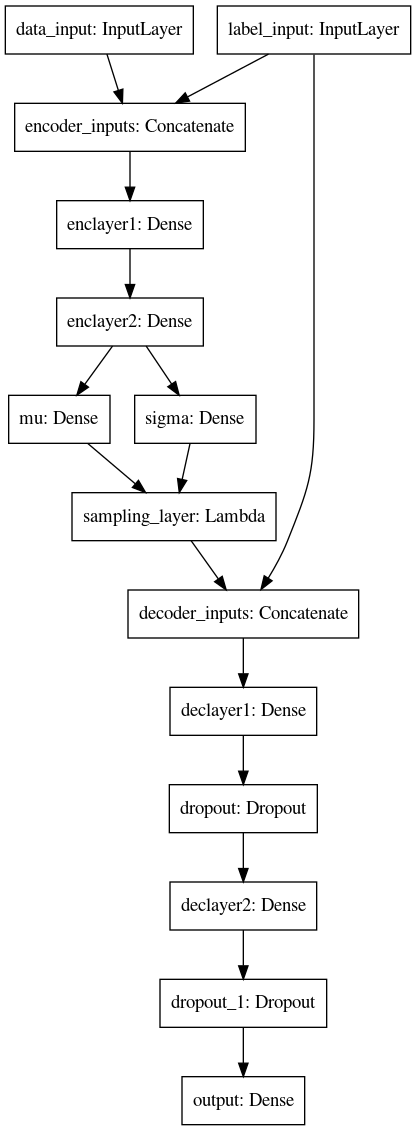

In [6]:
keras.utils.plot_model(cvae)

In [7]:
cvae.compile(optimizer='adam', loss=vae_loss)
cvae_hist = cvae.fit([x_train, y_train],
                     x_train,
                     verbose=0,
                     batch_size=batch_size,
                     epochs=30,
                     #validation_data=([x_test, y_test], x_test),
                     callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

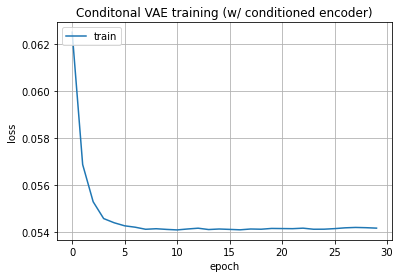

In [8]:
plt.plot(cvae_hist.history['loss'])
#plt.plot(cvae_hist.history['val_loss'])
plt.title('Conditonal VAE training (w/ conditioned encoder)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [9]:
cvae2_inp1    = keras.layers.Input(shape=(x_train.shape[1],), name='cvae2_data_input')

x             = keras.layers.Dense(512, activation='relu', name='cvae2_enclayer1')(cvae2_inp1)
x             = keras.layers.Dropout(0.2)(x)
x             = keras.layers.Dense(512, activation='relu', name='cvae2_enclayer2')(x)
x             = keras.layers.Dropout(0.2)(x)


cvae2_mu        = keras.layers.Dense(latent_dim, activation='linear', name='cvae2_mu')(x)
cvae2_log_sigma = keras.layers.Dense(latent_dim, activation='linear', name='cvae2_sigma')(x)


def cvae2_sample_z(args):
    cvae2_mu, cvae2_log_sigma = args
    eps                       = K.random_normal(shape=(K.shape(cvae2_mu)[0], latent_dim), mean=0., stddev=1.)
    return cvae2_mu + K.exp(cvae2_log_sigma / 2) * eps


cvae2_labels  = keras.layers.Input(shape=(1,), name='cvae2_label_input')



cvae2_z      = keras.layers.Lambda(cvae2_sample_z, name='cvae2_sampling_layer')([cvae2_mu, cvae2_log_sigma])
cvae2_z_cond = keras.layers.concatenate([cvae2_z, cvae2_labels], name='cvae2_decoder_inputs')


x           = keras.layers.Dense(512, activation='relu', name='cvae2_declayer1')(cvae2_z_cond)
x           = keras.layers.Dropout(0.2)(x)
x           = keras.layers.Dense(512, activation='relu', name='cvae2_declayer2')(x)
x           = keras.layers.Dropout(0.2)(x)
cvae2_decoder_out = keras.layers.Dense(x_train.shape[1], activation='linear', name='cvae2_output')(x)


def cvae2_vae_loss(y_true, y_pred):
    recon = K.mean(K.square(y_pred - y_true), axis=-1)
    kl = kl_weight * K.sum(K.exp(cvae2_log_sigma) + K.square(cvae2_mu) - 1. - cvae2_log_sigma, axis=1)

    return recon + kl


cvae2_encoder = keras.Model(cvae2_inp1, [cvae2_mu, cvae2_log_sigma])
#decoder = keras.Model([])

cvae2 = keras.Model([cvae2_inp1,cvae2_labels], cvae2_decoder_out)

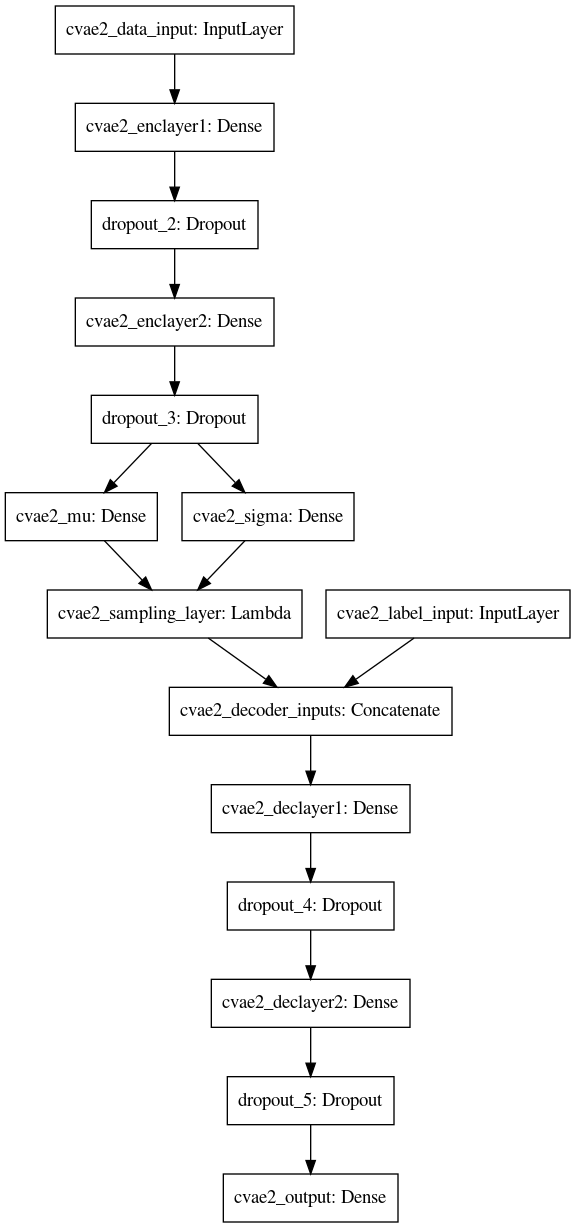

In [10]:
keras.utils.plot_model(cvae2)

In [11]:
cvae2.compile(optimizer='adam', loss=cvae2_vae_loss)
cvae2_hist = cvae.fit([x_train, y_train],
                     x_train,
                     verbose=0,
                     batch_size=32,
                     epochs=10,
                     validation_data=([x_test, y_test], x_test),
                     callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

InvalidArgumentError: Incompatible shapes: [16,2] vs. [32,2]
	 [[{{node sampling_layer/mul}}]]

In [ ]:
plt.plot(cvae2_hist.history['loss'])
#plt.plot(cvae_hist.history['val_loss'])
plt.title('Conditonal VAE training (w/ conditioned encoder)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [12]:
from keras import layers
from tensorflow.keras import backend as K


#tf.compat.v1.enable_eager_execution()


original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2


#
labels  = keras.layers.Input(shape=(1,))
#

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
h = layers.Dropout(0.2)(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')




# Create decoder
z_sampling = keras.Input(shape=(latent_dim,), name='z_sampling')

#
z_cond = layers.concatenate([z_sampling, labels])
#

x = layers.Dense(intermediate_dim, activation='relu')(z_cond)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = keras.Model([z_sampling, labels], outputs, name='decoder')

# instantiate VAE model
outputs = decoder([encoder(inputs)[2], labels])


vae = keras.Model([inputs, labels], outputs, name='vae_mlp')

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


vae.compile(optimizer='adam', metrics=[keras.losses.binary_crossentropy])



vae.fit([x_train, y_train], x_train,
        epochs=100,
        batch_size=32,
        validation_data=([x_test, y_test], x_test))


ValueError: ('Error when checking model target: expected no data, but got:', array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]))

In [18]:
x_train_encoded = encoder.predict(x_train, batch_size=32)

len(x_train_encoded)

3

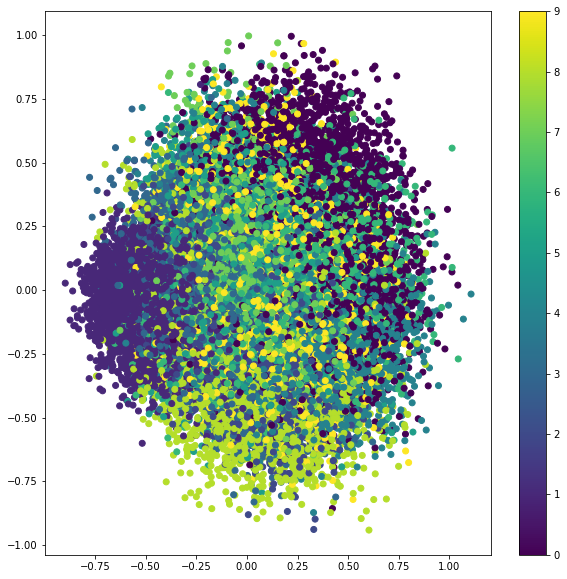

In [21]:
x_train_encoded = encoder.predict(x_train, batch_size=32)[2]
plt.figure(figsize=(10, 10))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=y_train)
plt.colorbar()
plt.show()


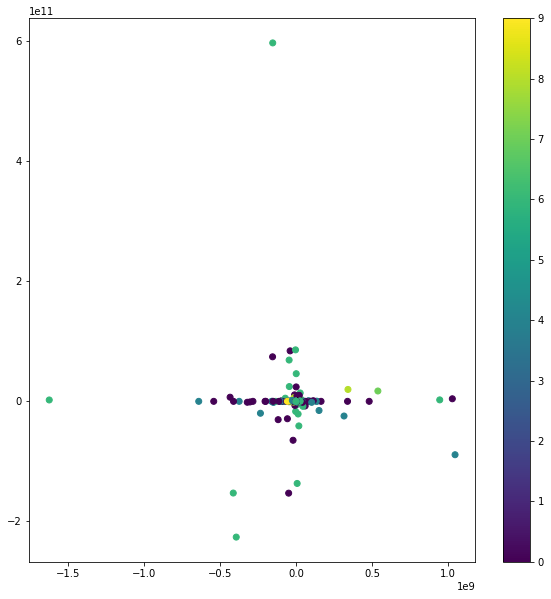

In [23]:
x_test_encoded = encoder.predict(x_test, batch_size=32)[2]
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
